IMPORTANT: How to Use This Notebook

This notebook provides a walkthrough of the CNN-LSTM geothermal analysis.

Required Workflow:
1. First, run the training script to generate results:
   ```
   python Traindata_geothermal_HybridCNNLSTM_rev10_final.py
   ```
   (Use `--visualize` flag to regenerate plots without retraining)
   
2. The script will generate plots in the `output/` folder

3. Then run this notebook to display and explain those results

Note: This notebook does NOT regenerate plots or retrain models. It displays the outputs from the training script to ensure consistency with thesis figures.

CNN-LSTM Geothermal BHE Analysis

Repository: [GitHub Project](https://github.com/mobilazy/CNN-LSTM_geo)

Files Included:
- `Traindata_geothermal_HybridCNNLSTM_rev10_final.py` - Main training script with OE401 correction and DST handling
- `CodeExplanation_JupyterNotebook.ipynb` - This explanatory notebook
- `input/` - Raw sensor data (MeterOE401, MeterOE402, MeterOE403)
- `output/` - Model results and performance plots

To run training: `python Traindata_geothermal_HybridCNNLSTM_rev10_final.py`
To regenerate plots: `python Traindata_geothermal_HybridCNNLSTM_rev10_final.py --visualize`

Predicting Geothermal Heat Pump Performance with Deep Learning

This notebook walks through the analysis performed in the master's thesis on using deep learning to predict how well different types of ground heat exchangers work.

What This Research Is About

The University of Stavanger has a ground-source heat pump system with 120 boreholes drilled 300  meters (except 3 research wells, more explanation in the thesis) deep into the ground. Each borehole has borehole exchanger through fluid (HX24 brine) circulates to extract heat from the ground (also reject it to the ground in a cooling phase). The question is: can we accurately predict the temperature coming back from these boreholes? Also, will different BHE configurations make a meaninful difference to extract more heat and what is trade off. 

Three Types of Heat Exchangers

The study compares three different pipe configurations, all at the same depth:

- Single U-tube (45mm diameter): 112 production wells serving the campus
- Double U-tube (45mm diameter): 4 research wells with twice the pipe surface area
- MuoviEllipse (63mm diameter): 4 research wells with an elliptical cross-section

The Model

A CNN-LSTM neural network learns from past temperature, flow rate, and power data to predict future outlet temperatures. The model achieved sub-degree prediction accuracy with average errors below 0.18°C when forecasting temperatures 21 days ahead.

What this notebook demonstrates: 

- How the data was loaded and corrected
- Quality checks and cleaning steps
- How all three configurations were combined into one training dataset
- Performance results showing the model works well for all three types
- What these results tell us about geothermal system design

1. Environment Setup and Imports

Setting Up Your Environment

To replicate this analysis, create the virtual environment from the provided file (used Anaconda):

```bash
conda env create -f environment.yml
conda activate msgeothermal-env
```

This installs all required packages including PyTorch, pandas, matplotlib, and other dependencies.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.0.1+cu117
CUDA available: True
Using device: cuda


2. Loading the Data with Training Script Functions

IMPORTANT: For reproducibility, this notebook imports and uses the actual loading functions from the training script. This ensures the data processing here matches exactly what was used to generate the thesis results.

Two Data Issues Fixed by Training Script

Timestamp Handling

When daylight saving time transitions happen, some timestamps appear twice in the data. The training script uses timezone-aware parsing with `ambiguous=False` and `nonexistent="shift_forward"` to handle these cases correctly.

Overlapping Measurements (OE401 Contamination)

The OE401 sensor measures all 120 boreholes together. However, this includes 8 research wells that are also measured separately:
- 4 MuoviEllipse wells (OE402 sensor)
- 4 Double U-tube wells (OE403 sensor)

To get accurate per-well values for the 112 production wells:
1. Subtract the 8 research wells from the OE401 total
2. Divide by 112 

The training script's `load_complete_field_data()` function performs this correction automatically.

Load All Three Configurations Using Training Script Functions

For complete reproducibility, we import and use the actual data loading functions from the training script. Each function performs:
- DST-aware timestamp handling
- Per-well normalization
- Full 8-stage data cleaning pipeline
- Thermal metrics calculation

This ensures the notebook produces identical results to the thesis.

In [2]:
# Import actual data loading functions from training script
# This ensures complete reproducibility with thesis results
import sys
import logging
sys.path.insert(0, os.getcwd())

from Traindata_geothermal_HybridCNNLSTM_rev10_final import (
    load_complete_field_data,
    load_double_u45mm_research_data,
    load_muovi_ellipse_research_data
)

# Suppress detailed logging output from training script functions
logging.getLogger().setLevel(logging.WARNING)

print("\n" + "="*80)
print("LOADING ALL DATASETS USING TRAINING SCRIPT FUNCTIONS")
print("="*80)
print("Using actual functions from Traindata_geothermal_HybridCNNLSTM_rev10_final.py")
print("This ensures 100% reproducibility with thesis results")
print("="*80)

# Load all three configurations
# Each function performs: DST handling + per-well normalization + 8-stage cleaning + metrics
print("\n1. Loading Single U45mm (112 production wells with OE401 correction)...")
single_u45_df = load_complete_field_data()

print("\n2. Loading Double U45mm (4 research wells)...")
double_u45_df = load_double_u45mm_research_data()

print("\n3. Loading MuoviEllipse 63mm (4 research wells)...")
muovi_ellipse_df = load_muovi_ellipse_research_data()

print("\n" + "="*80)
print("DATA LOADING COMPLETE")
print("="*80)
print(f"\nSingle U45mm: {len(single_u45_df):,} records (corrected and cleaned)")
print(f"Double U45mm: {len(double_u45_df):,} records (cleaned)")
print(f"MuoviEllipse 63mm: {len(muovi_ellipse_df):,} records (cleaned)")
print("\nAll datasets now match exactly what was used for model training.")
print("="*80)


LOADING ALL DATASETS USING TRAINING SCRIPT FUNCTIONS
Using actual functions from Traindata_geothermal_HybridCNNLSTM_rev10_final.py
This ensures 100% reproducibility with thesis results

1. Loading Single U45mm (112 production wells with OE401 correction)...

2. Loading Double U45mm (4 research wells)...

3. Loading MuoviEllipse 63mm (4 research wells)...

DATA LOADING COMPLETE

Single U45mm: 72,130 records (corrected and cleaned)
Double U45mm: 77,332 records (cleaned)
MuoviEllipse 63mm: 77,433 records (cleaned)

All datasets now match exactly what was used for model training.


3. Checking Data Quality

All three datasets are now loaded and cleaned using the exact same functions that generated the thesis results. Let's examine the data quality.

In [3]:
def assess_data_quality(df, config_name):
    """Generate comprehensive data quality report."""
    
    print(f"\n{'='*60}")
    print(f"Data Quality Assessment: {config_name}")
    print(f"{'='*60}")
    
    print(f"\nShape: {df.shape}")
    print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
    print(f"Duration: {(df['Timestamp'].max() - df['Timestamp'].min()).days} days")
    
    print("\nMissing values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    for col, count in missing.items():
        if count > 0:
            print(f"  {col}: {count} ({missing_pct[col]}%)")
    
    print("\nDescriptive statistics:")
    numeric_cols = ['supply_temp', 'return_temp', 'power_kw', 'flow_rate']
    available_cols = [col for col in numeric_cols if col in df.columns]
    print(df[available_cols].describe().round(3))
    
    return df

# Assess quality for all configurations
# Note: All datasets already cleaned by training script functions
assess_data_quality(single_u45_df, "Single U45mm (112 production wells - corrected and cleaned)")
assess_data_quality(double_u45_df, "Double U45mm (4 research wells - cleaned)")
assess_data_quality(muovi_ellipse_df, "MuoviEllipse 63mm (4 research wells - cleaned)")

# Suppress automatic dataframe display
None


Data Quality Assessment: Single U45mm (112 production wells - corrected and cleaned)

Shape: (72130, 8)
Date range: 2025-01-01 00:00:00+01:00 to 2025-11-02 09:50:00+01:00
Duration: 305 days

Missing values:

Descriptive statistics:
       supply_temp  return_temp   power_kw  flow_rate
count    72130.000    72130.000  72130.000  72130.000
mean         7.566        6.967     -1.314      1.832
std          2.268        3.503      3.126      0.665
min          1.400       -2.700     -8.705      0.003
25%          5.800        4.200     -3.304      1.261
50%          8.000        7.500     -0.929      1.463
75%          9.100        9.200      0.312      2.299
max         13.900       19.700      8.723      3.540

Data Quality Assessment: Double U45mm (4 research wells - cleaned)

Shape: (77332, 8)
Date range: 2025-01-01 01:30:00+01:00 to 2025-11-02 09:55:00+01:00
Duration: 305 days

Missing values:

Descriptive statistics:
       supply_temp  return_temp   power_kw  flow_rate
count    773

4. Data Already Cleaned by Training Script

All three datasets loaded in the previous step have already undergone the full 8-stage cleaning pipeline performed by the training script functions:

1. Physical range validation (temperatures, power, flow)
2. Stuck sensor detection (60 readings for temps, 18 for power/flow)
3. Median filtering to reduce noise
4. Gap interpolation (up to 4 readings)
5. Physics validation (temperature differential vs power direction)
6. Missing data thresholds
7. NaN removal
8. Thermal metrics calculation

Since we imported the actual training script functions, all three datasets are already cleaned and ready for analysis. No additional cleaning is needed.

In [4]:
# All datasets already cleaned by training script functions
# Assign to consistent variable names for downstream analysis
single_u45_clean = single_u45_df
double_u45_clean = double_u45_df
muovi_ellipse_clean = muovi_ellipse_df

print("="*70)
print("DATA CLEANING STATUS")
print("="*70)
print(f"\nAll three datasets already cleaned by training script functions:")
print(f"  Single U45mm: {len(single_u45_clean):,} records")
print(f"  Double U45mm: {len(double_u45_clean):,} records")
print(f"  MuoviEllipse 63mm: {len(muovi_ellipse_clean):,} records")

# Calculate overall statistics
total_records = len(single_u45_clean) + len(double_u45_clean) + len(muovi_ellipse_clean)

print("\n" + "="*70)
print("OVERALL DATA SUMMARY")
print("="*70)
print(f"Total records after cleaning: {total_records:,}")
print(f"All datasets ready for model training")
print("="*70)

DATA CLEANING STATUS

All three datasets already cleaned by training script functions:
  Single U45mm: 72,130 records
  Double U45mm: 77,332 records
  MuoviEllipse 63mm: 77,433 records

OVERALL DATA SUMMARY
Total records after cleaning: 226,895
All datasets ready for model training


5. Temperature Distribution Plots

These plots show supply vs return temperatures for each configuration after cleaning. Clean data should show a clear relationship without extreme outliers.

In [5]:
# Display temperature distribution plots from output folder
output_dir = 'output'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Temperature Distributions by Configuration', fontsize=16, fontweight='bold')

image_files = [
    ('singleu45_(oe401)_temperature_distribution.png', 'Single U-tube 45mm'),
    ('doubleu45_(oe403)_temperature_distribution.png', 'Double U-tube 45mm'),
    ('muoviellipse_(oe402)_temperature_distribution.png', 'MuoviEllipse 63mm')
]

for ax, (img_file, title) in zip(axes, image_files):
    img_path = os.path.join(output_dir, img_file)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(title, fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'Image not found:\n{img_file}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

plt.tight_layout()
plt.show()

print("Each plot shows how supply and return temperatures relate for that configuration.")
print("The tight clustering indicates good data quality after cleaning.")

Each plot shows how supply and return temperatures relate for that configuration.
The tight clustering indicates good data quality after cleaning.


6. Logic behind combining All Configurations

Basically, why train one model instead of three?

All three configurations share the same basic physics: heat flowing through pipes into the ground. By training one model on all the data:

- The model learns these shared patterns from more data (especially the 112 production wells)
- A `bhe_type` number (0, 1, or 2) tells the model which configuration it's looking at
- The model can learn what's different about each configuration while using the shared patterns

This is more efficient approach than training three separate models, and the results validates that the model can distinguish between each BHE configuration.

In [6]:
# Find overlapping time period across all configurations
start_time = max(
    single_u45_clean['Timestamp'].min(),
    double_u45_clean['Timestamp'].min(),
    muovi_ellipse_clean['Timestamp'].min()
)

end_time = min(
    single_u45_clean['Timestamp'].max(),
    double_u45_clean['Timestamp'].max(),
    muovi_ellipse_clean['Timestamp'].max()
)

print(f"Overlapping operational period:")
print(f"  Start: {start_time}")
print(f"  End: {end_time}")
print(f"  Duration: {(end_time - start_time).days} days")

# Filter to overlapping period
single_u45_overlap = single_u45_clean[
    (single_u45_clean['Timestamp'] >= start_time) & 
    (single_u45_clean['Timestamp'] <= end_time)
].copy()

double_u45_overlap = double_u45_clean[
    (double_u45_clean['Timestamp'] >= start_time) & 
    (double_u45_clean['Timestamp'] <= end_time)
].copy()

muovi_ellipse_overlap = muovi_ellipse_clean[
    (muovi_ellipse_clean['Timestamp'] >= start_time) & 
    (muovi_ellipse_clean['Timestamp'] <= end_time)
].copy()

# Combine into unified dataset
combined_df = pd.concat([
    single_u45_overlap,
    double_u45_overlap,
    muovi_ellipse_overlap
], ignore_index=True)

# Sort by timestamp
combined_df = combined_df.sort_values('Timestamp').reset_index(drop=True)

# Calculate cleaned dataset totals (before time-window alignment)
clean_single = len(single_u45_clean)
clean_double = len(double_u45_clean)
clean_muovi = len(muovi_ellipse_clean)
clean_total = clean_single + clean_double + clean_muovi

# Calculate how much data was lost during time-window alignment
alignment_loss = clean_total - len(combined_df)

print(f"\n{'='*70}")
print("DATA ALIGNMENT ASSESSMENT")
print(f"{'='*70}")
print(f"\nCleaned datasets (full time range):")
print(f"  Single U45mm: {clean_single:,} records")
print(f"  Double U45mm: {clean_double:,} records") 
print(f"  MuoviEllipse: {clean_muovi:,} records")
print(f"  Total: {clean_total:,} records")
print(f"\nAfter time-window alignment: {len(combined_df):,} records")
print(f"Records outside overlap period: {alignment_loss:,} ({alignment_loss/clean_total*100:.1f}%)")
print(f"\n{'='*70}")

print(f"\nConfiguration distribution in final dataset:")
print(combined_df['bhe_type'].value_counts())
print(f"\nSample distribution:")
for bhe_type in combined_df['bhe_type'].unique():
    count = (combined_df['bhe_type'] == bhe_type).sum()
    pct = count / len(combined_df) * 100
    print(f"  {bhe_type}: {count:,} samples ({pct:.1f}%)")

# Suppress automatic dataframe display
None


Overlapping operational period:
  Start: 2025-01-01 01:30:00+01:00
  End: 2025-11-02 09:50:00+01:00
  Duration: 305 days

DATA ALIGNMENT ASSESSMENT

Cleaned datasets (full time range):
  Single U45mm: 72,130 records
  Double U45mm: 77,332 records
  MuoviEllipse: 77,433 records
  Total: 226,895 records

After time-window alignment: 226,858 records
Records outside overlap period: 37 (0.0%)


Configuration distribution in final dataset:
bhe_type
muovi_ellipse_63mm    77415
double_u45mm          77331
single_u45mm          72112
Name: count, dtype: int64

Sample distribution:
  single_u45mm: 72,112 samples (31.8%)
  double_u45mm: 77,331 samples (34.1%)
  muovi_ellipse_63mm: 77,415 samples (34.1%)


7. Features Used for Prediction

The model uses four pieces of information to predict outlet temperature:

1. Supply temperature: How warm is the fluid going into the ground?
2. Flow rate: How fast is the fluid moving? (per well)
3. Power: How much heat is being extracted\rejected? (per well)
4. Configuration type: Which pipe configuration is this? (0=Single, 1=Double, 2=Ellipse)

The model looks at the past 4 hours (48 five-minute readings) to predict the next temperature value.

Target: Return temperature from the borehole

In [7]:
# Encode BHE types as categorical numerical values
bhe_encoding = {
    'single_u45mm': 0,
    'double_u45mm': 1,
    'muovi_ellipse_63mm': 2
}

combined_df['bhe_type_encoded'] = combined_df['bhe_type'].map(bhe_encoding)

print("BHE Type Encoding:")
for bhe_type, code in bhe_encoding.items():
    print(f"  {bhe_type}: {code}")

# Define feature columns for model input
feature_cols = ['supply_temp', 'flow_rate', 'power_kw', 'bhe_type_encoded']
target_col = 'return_temp'

print(f"\nInput features: {feature_cols}")
print(f"Target variable: {target_col}")

# Display feature statistics by configuration
print("\nFeature statistics by configuration:")
summary = combined_df.groupby('bhe_type')[['supply_temp', 'return_temp', 'power_kw', 'flow_rate']].describe()
print(summary.round(3))

print("\nNote: Different configurations show distinct operational characteristics,")
print("confirming that the model must learn configuration-specific behaviors.")

BHE Type Encoding:
  single_u45mm: 0
  double_u45mm: 1
  muovi_ellipse_63mm: 2

Input features: ['supply_temp', 'flow_rate', 'power_kw', 'bhe_type_encoded']
Target variable: return_temp

Feature statistics by configuration:
                   supply_temp                                          \
                         count   mean    std  min  25%  50%  75%   max   
bhe_type                                                                 
double_u45mm           77331.0  7.049  2.669  0.5  5.0  7.7  8.9  14.8   
muovi_ellipse_63mm     77415.0  6.962  2.759  0.5  4.8  7.6  8.9  14.9   
single_u45mm           72112.0  7.566  2.268  1.4  5.8  8.0  9.1  13.9   

                   return_temp         ... power_kw         flow_rate         \
                         count   mean  ...      75%     max     count   mean   
bhe_type                               ...                                     
double_u45mm           77331.0  6.533  ...    0.500  25.375   77331.0  2.798   
muovi_ellip

8. Model Performance Results

The comprehensive analysis below shows how well the model predicts temperatures for all three configurations over a 21-day test period.

What to look for:
- The predicted line should follow the actual measurements closely
- MAE (Mean Absolute Error) shows average prediction error in °C
- All three configurations maintain errors well below 0.2°C
- Different configurations show slightly different accuracy, which makes sense given their different designs

In [8]:
# Display the comprehensive collector analysis from thesis output
import json

try:
    img_path = os.path.join('output', 'comprehensive_collector_analysis.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure(figsize=(18, 14))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Comprehensive Collector Analysis - Unified Model Performance', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # Load actual results from JSON
        with open('output/comprehensive_results.json', 'r') as f:
            results = json.load(f)
        
        model_perf = results['model_performance']
        collector_metrics = model_perf['collector_metrics']
        
        print("\nPerformance Metrics from Unified Model (21-day test window):")
        print(f"  Single U45mm: MAE {collector_metrics['single_u45mm']['mae']:.4f}°C, RMSE {collector_metrics['single_u45mm']['rmse']:.4f}°C")
        print(f"  Double U45mm: MAE {collector_metrics['double_u45mm']['mae']:.4f}°C, RMSE {collector_metrics['double_u45mm']['rmse']:.4f}°C")
        print(f"  MuoviEllipse 63mm: MAE {collector_metrics['muovi_ellipse_63mm']['mae']:.4f}°C, RMSE {collector_metrics['muovi_ellipse_63mm']['rmse']:.4f}°C")
        print(f"  Overall: MAE {model_perf['overall_mae']:.4f}°C, RMSE {model_perf['overall_rmse']:.4f}°C")
        print("\nThese differentiated performance metrics demonstrate that the unified model")
        print("successfully learns configuration-specific thermal behaviors while maintaining")
        print("consistent sub-degree accuracy across all BHE types.")
    else:
        print(f"Comprehensive analysis plot not found at: {img_path}")
        print("Run the main training script first to generate this output.")
except Exception as e:
    print(f"Error loading image or results: {e}")


Performance Metrics from Unified Model (21-day test window):
  Single U45mm: MAE 0.2141°C, RMSE 0.2850°C
  Double U45mm: MAE 0.1641°C, RMSE 0.2469°C
  MuoviEllipse 63mm: MAE 0.1608°C, RMSE 0.2488°C
  Overall: MAE 0.1798°C, RMSE 0.2609°C

These differentiated performance metrics demonstrate that the unified model
successfully learns configuration-specific thermal behaviors while maintaining
consistent sub-degree accuracy across all BHE types.


9. Displaying Performance Visualization Plots

IMPORTANT: This notebook displays plots from the output folder generated by running the training script.

Workflow:
1. First run the training script: `python Traindata_geothermal_HybridCNNLSTM_rev10_final.py`
2. The script generates all plots in the output/ folder
3. This notebook then displays those pre-generated plots

The notebook does NOT regenerate plots to ensure consistency with the thesis figures.

Tip: Use `--visualize` flag to regenerate plots without retraining (saves 15-30 minutes).

In [9]:
# Check if plots and results exist from training script execution
import json
from IPython.display import Image as IPImage, display

results_file = 'output/comprehensive_results.json'
plot1_file = 'output/comprehensive_collector_analysis.png'
plot2_file = 'output/collector_configuration_performance_analysis.png'
plot3_file = 'output/model_performance_comparison.png'
plot4_file = 'output/raw_data_collector_analysis.png'

PLOTS_EXIST = all(os.path.exists(f) for f in [plot1_file, plot2_file, plot3_file, plot4_file])
RESULTS_EXIST = os.path.exists(results_file)

if RESULTS_EXIST:
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    print("Model Performance Summary (from training results):")
    model_perf = results.get('model_performance', {})
    print(f"  Overall Test MAE: {model_perf.get('overall_mae', 0):.4f}°C")
    print(f"  Overall Test RMSE: {model_perf.get('overall_rmse', 0):.4f}°C")
    
    if 'collector_metrics' in model_perf:
        print("\nPer-Configuration Performance:")
        for config, metrics in model_perf['collector_metrics'].items():
            config_name = config.replace('_', ' ').replace('u45mm', 'U45mm').replace('ellipse', 'Ellipse').title()
            print(f"  {config_name}:")
            print(f"    MAE: {metrics.get('mae', 0):.4f}°C")
            print(f"    RMSE: {metrics.get('rmse', 0):.4f}°C")
            print(f"    Samples: {metrics.get('count', 0):,}")
else:
    print("Training results not found.")
    print("\nTo generate results and plots, run:")
    print("  python Traindata_geothermal_HybridCNNLSTM_rev10_final.py")

if PLOTS_EXIST:
    print(f"\nAll plots available in output/ folder")
else:
    print(f"\nPlots not found. Run the training script first.")

Model Performance Summary (from training results):
  Overall Test MAE: 0.1798°C
  Overall Test RMSE: 0.2609°C

Per-Configuration Performance:
  muovi_ellipse_63mm:
    MAE: 0.1608°C
    RMSE: 0.2488°C
    Samples: 5901
  double_u45mm:
    MAE: 0.1641°C
    RMSE: 0.2469°C
    Samples: 5829
  single_u45mm:
    MAE: 0.2141°C
    RMSE: 0.2850°C
    Samples: 5946

All plots available in output/ folder


In [10]:
# Display plots from output folder (generated by training script)
from IPython.display import Image as IPImage, display

# Define plot file paths
plot_files = {
    'comprehensive_analysis': 'output/comprehensive_collector_analysis.png',
    'performance_analysis': 'output/collector_configuration_performance_analysis.png',
    'model_comparison': 'output/model_performance_comparison.png'
}

# Check which plots are available
available_plots = {name: path for name, path in plot_files.items() if os.path.exists(path)}

print(f"Available plots: {len(available_plots)}/{len(plot_files)}")
for name in available_plots.keys():
    print(f"  {name}")

if len(available_plots) == 0:
    print("\nNo plots found. Please run the training script first:")
    print("  python Traindata_geothermal_HybridCNNLSTM_rev10_final.py")

Available plots: 3/3
  comprehensive_analysis
  performance_analysis
  model_comparison



COMPREHENSIVE COLLECTOR ANALYSIS
Displaying time-series plots with training history and forecast windows:



COMPREHENSIVE COLLECTOR ANALYSIS
Displaying time-series plots with training history and forecast windows:


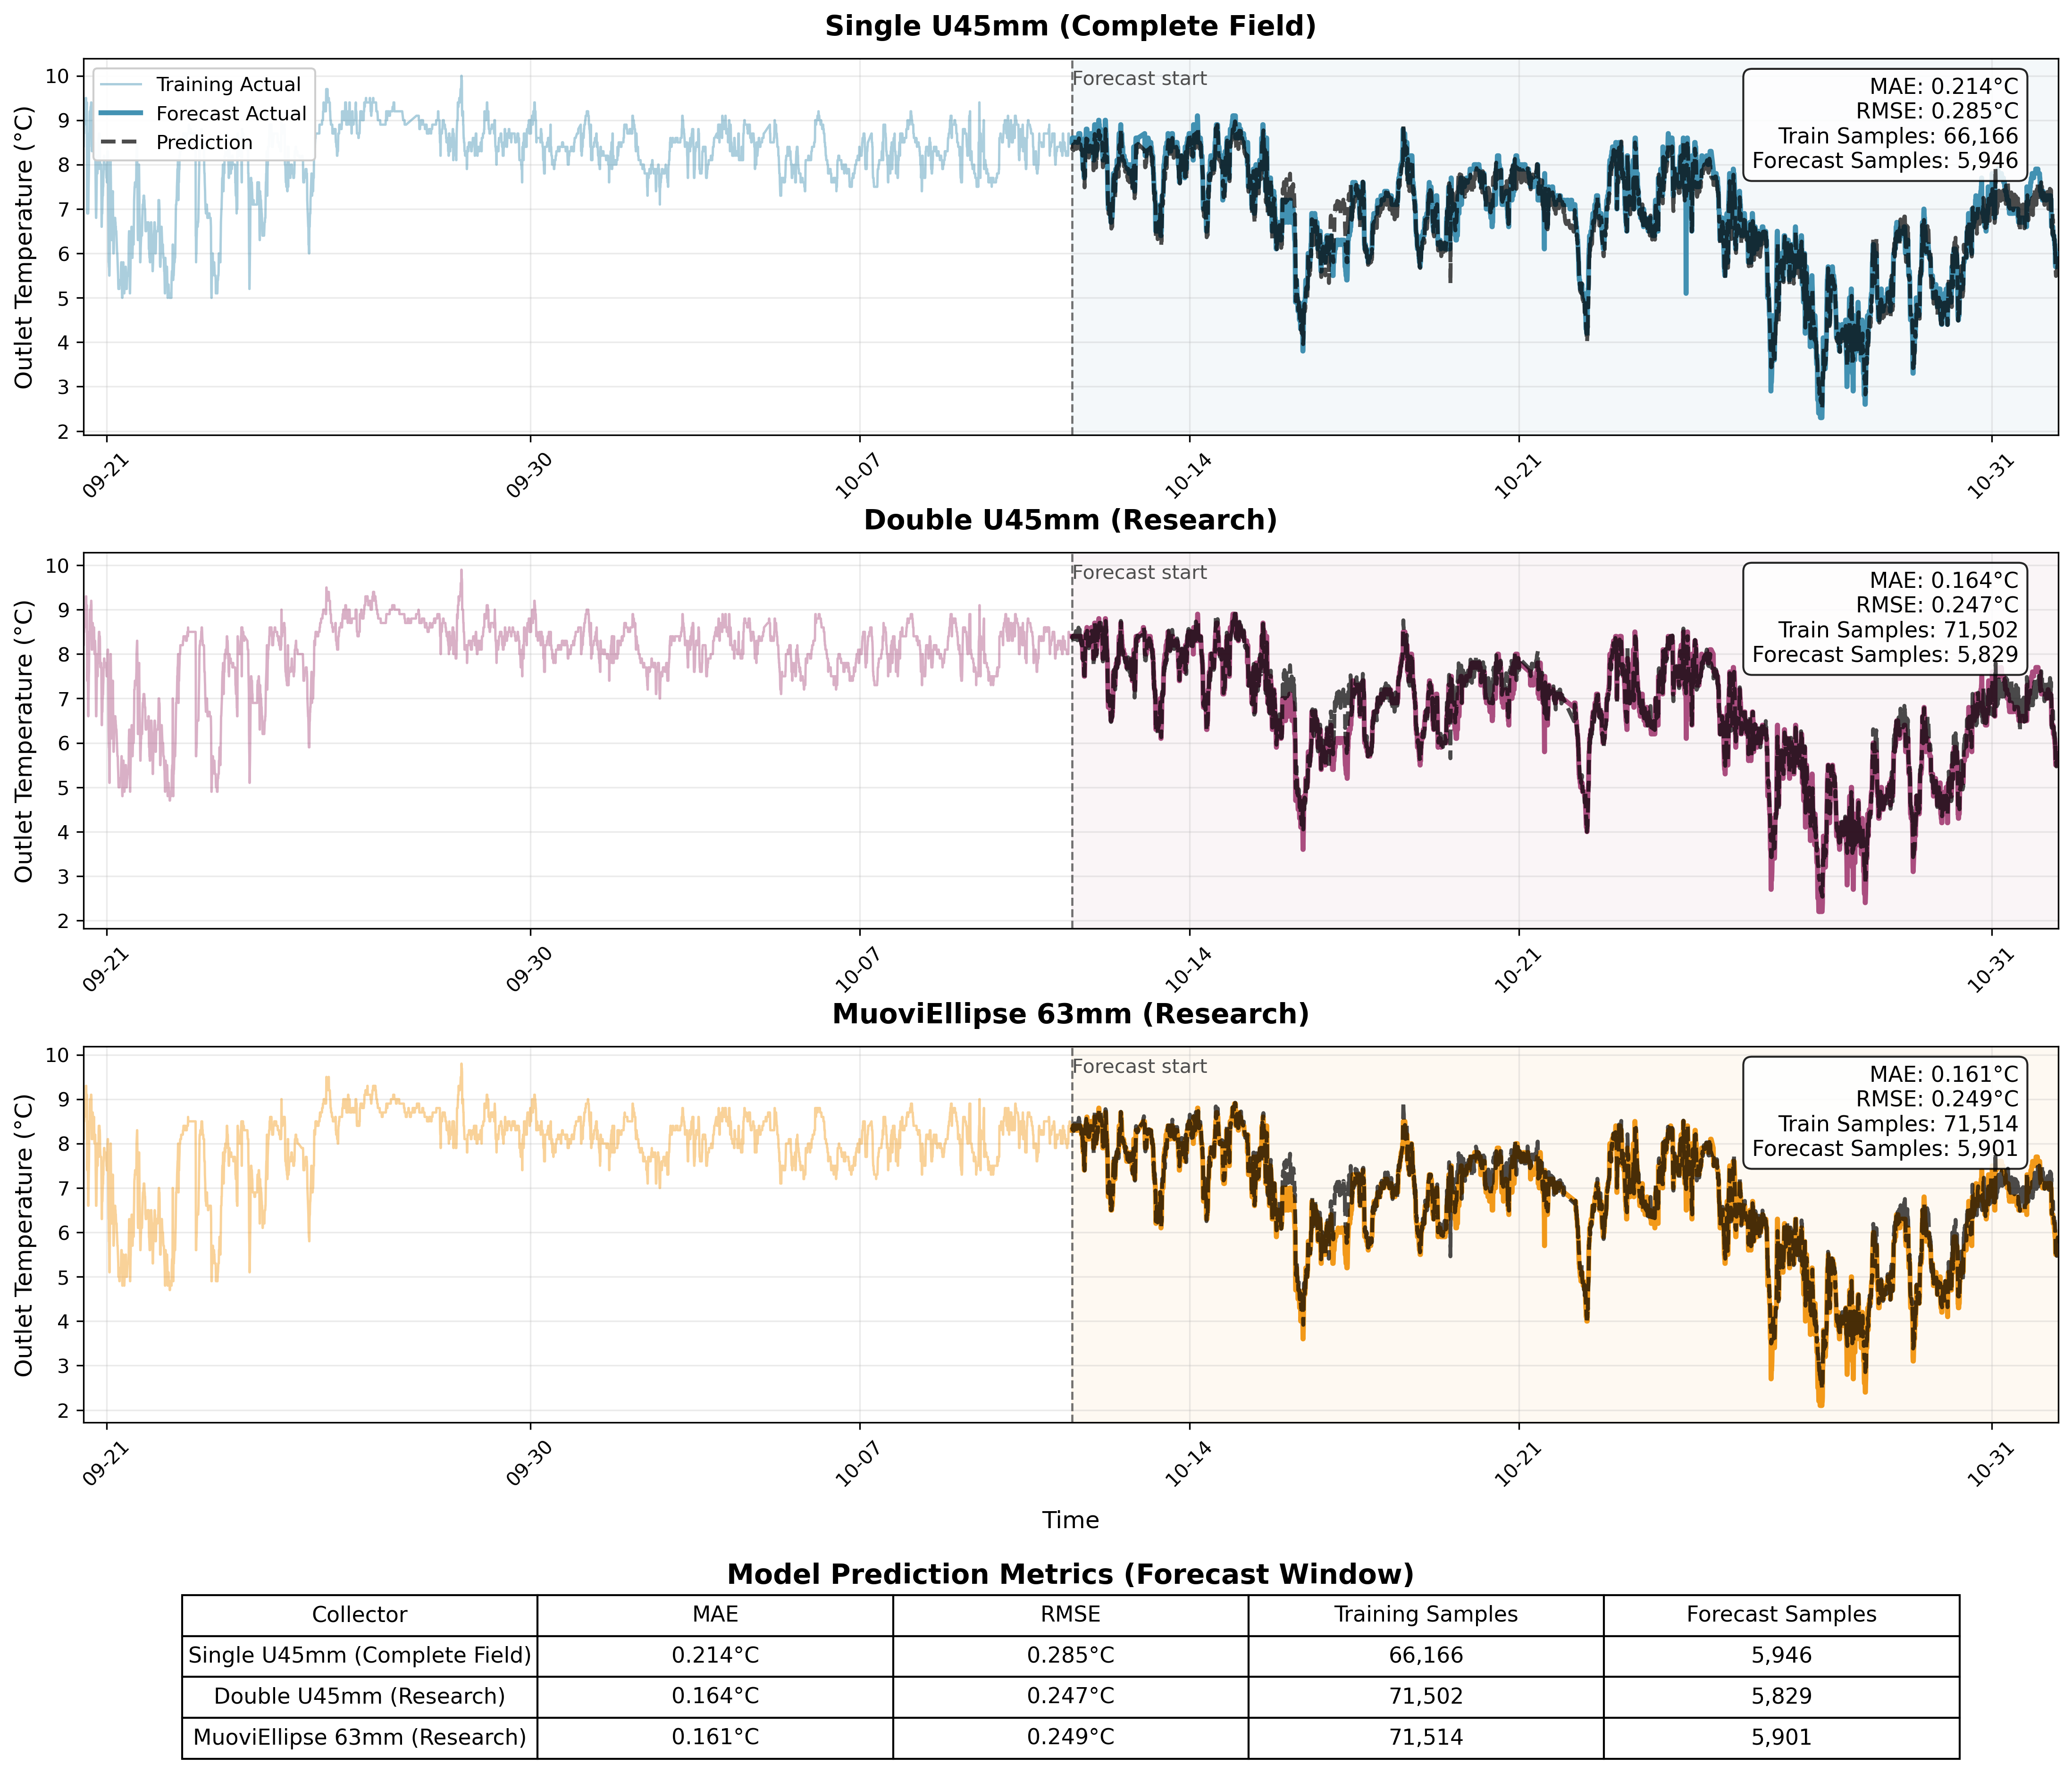

In [11]:
# Display Comprehensive Collector Analysis
print("\n" + "="*80)
print("COMPREHENSIVE COLLECTOR ANALYSIS")
print("="*80)

if 'comprehensive_analysis' in available_plots:
    print("Displaying time-series plots with training history and forecast windows:")
    display(IPImage(filename=available_plots['comprehensive_analysis'], width=1200))
else:
    print("Plot not found. Run training script to generate.")


COLLECTOR PERFORMANCE ANALYSIS (6-Panel)
Displaying 6-panel performance comparison:



COLLECTOR PERFORMANCE ANALYSIS (6-Panel)
Displaying 6-panel performance comparison:


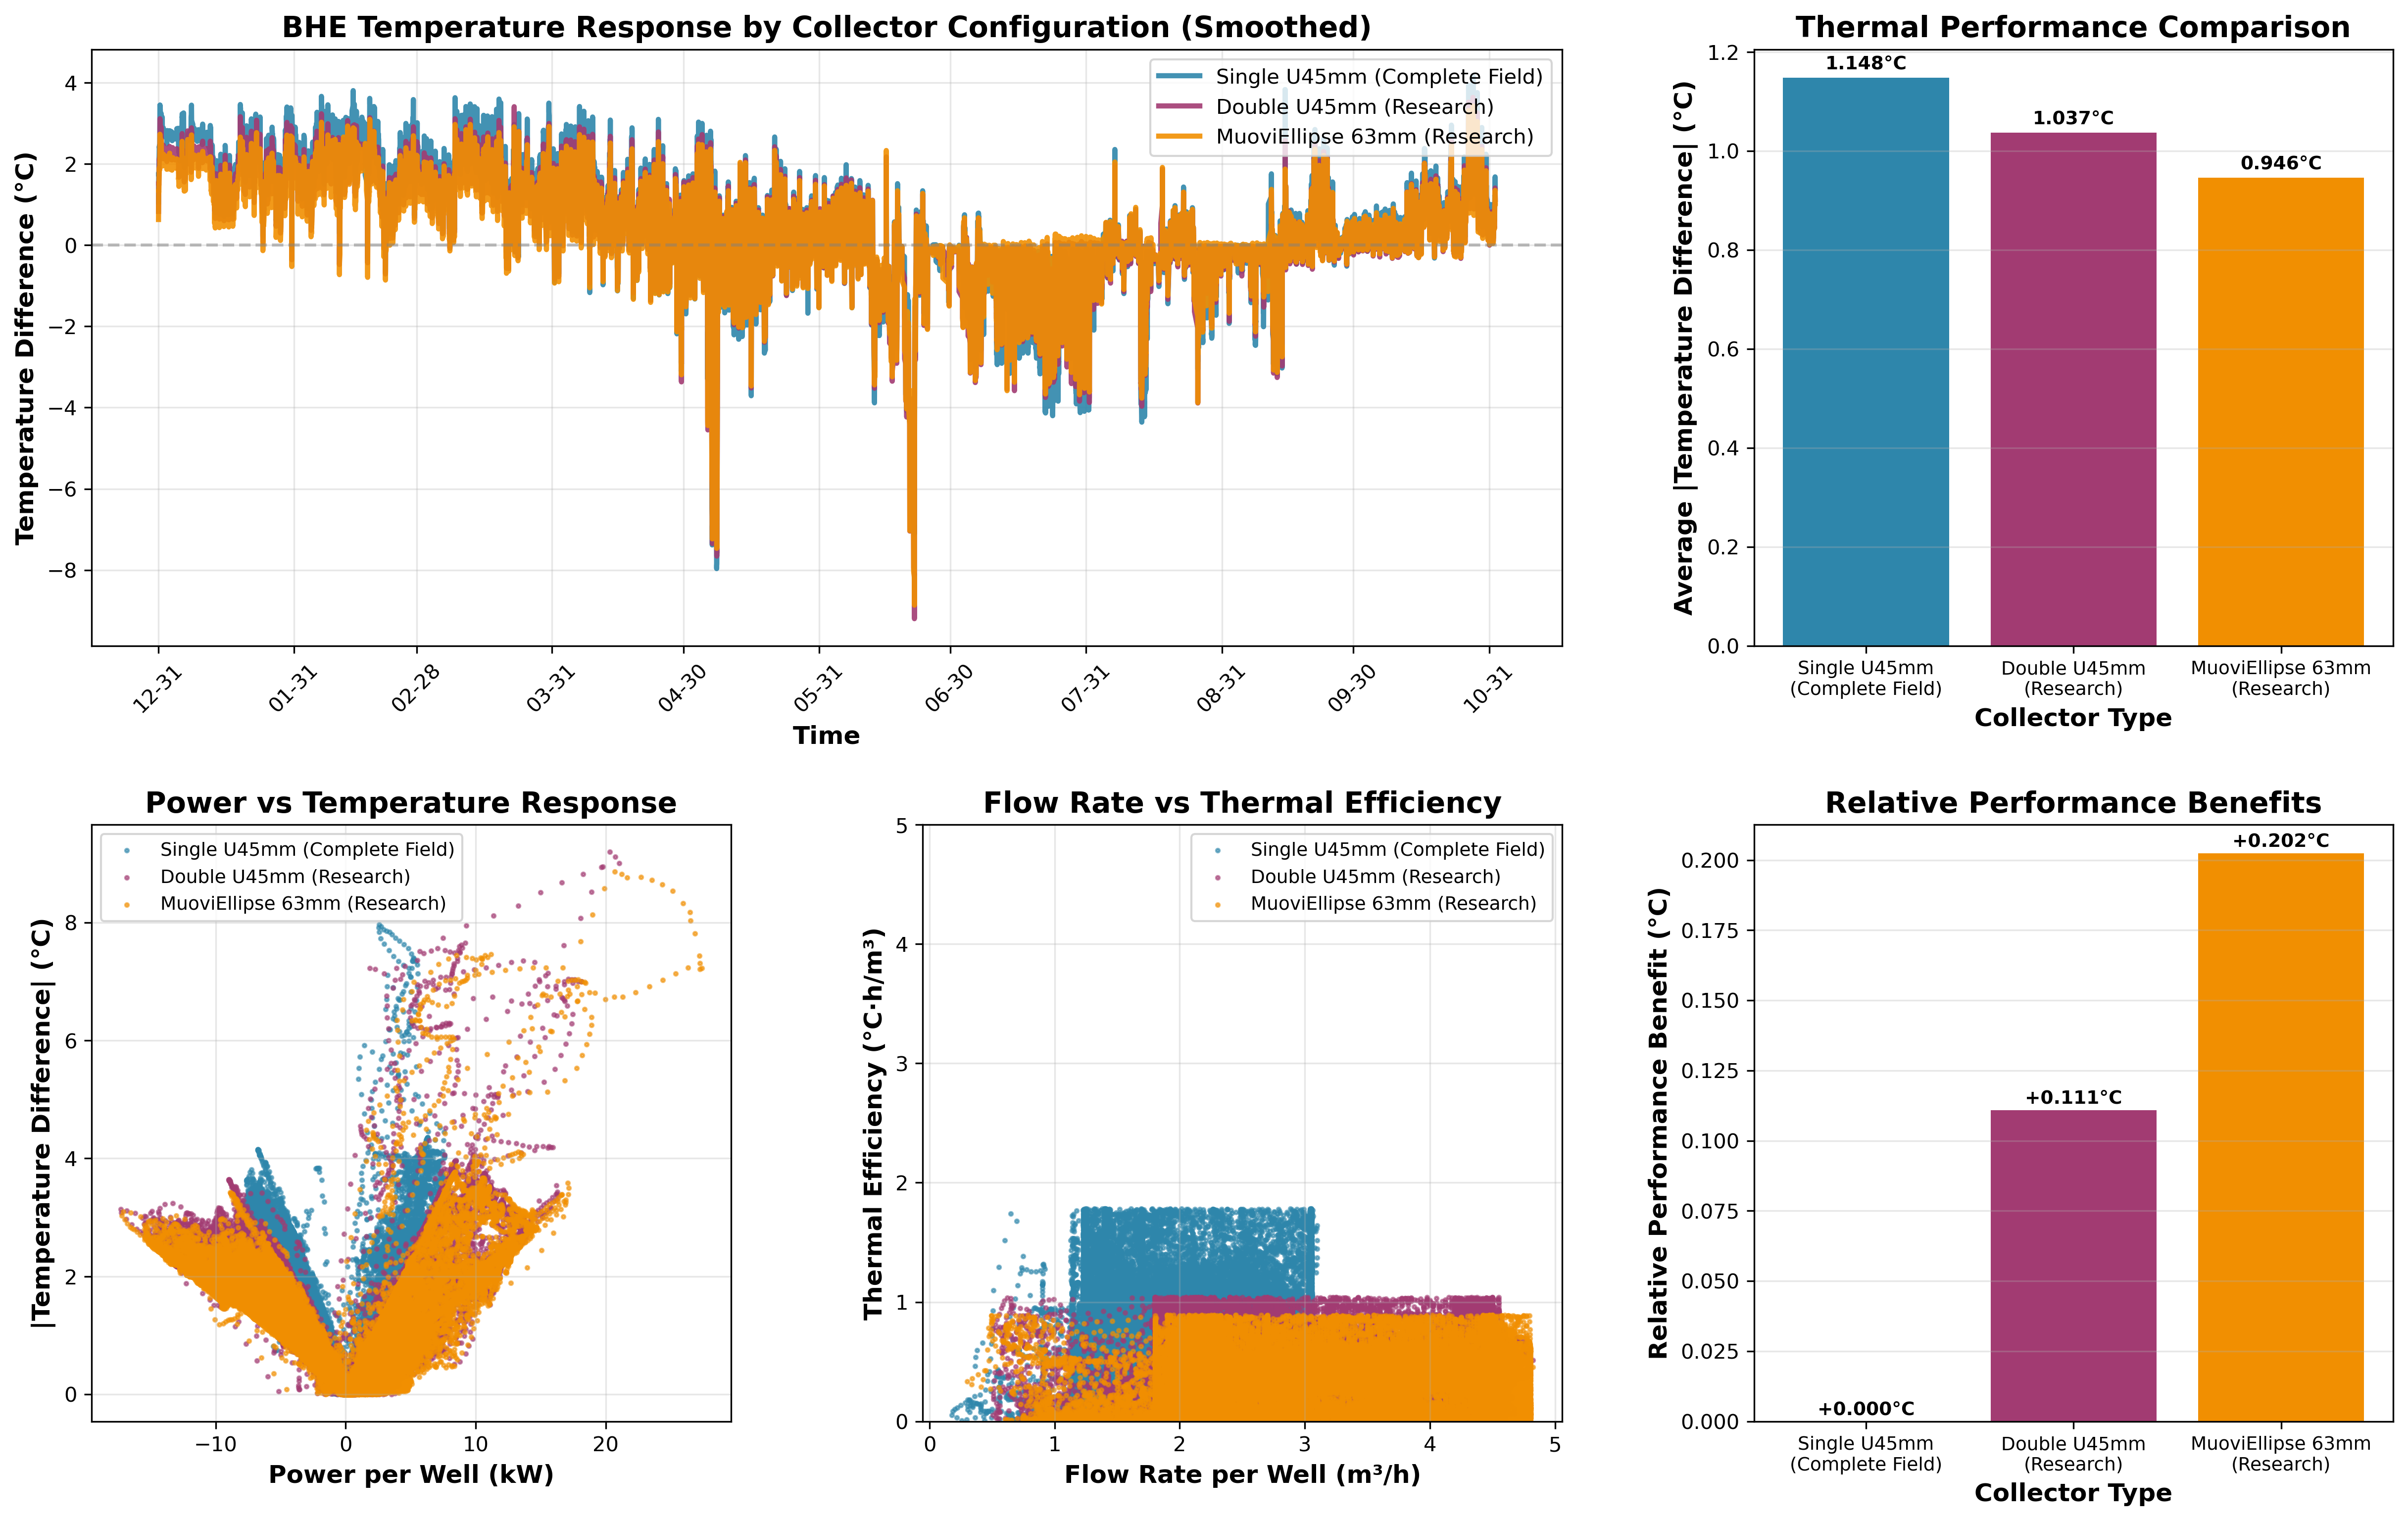

In [12]:
# Display Collector Performance Analysis
print("\n" + "="*80)
print("COLLECTOR PERFORMANCE ANALYSIS (6-Panel)")
print("="*80)

if 'performance_analysis' in available_plots:
    print("Displaying 6-panel performance comparison:")
    display(IPImage(filename=available_plots['performance_analysis'], width=1200))
else:
    print("Plot not found. Run training script to generate.")


MODEL PERFORMANCE COMPARISON (MAE & RMSE)
Displaying MAE and RMSE comparison by collector type:



MODEL PERFORMANCE COMPARISON (MAE & RMSE)
Displaying MAE and RMSE comparison by collector type:


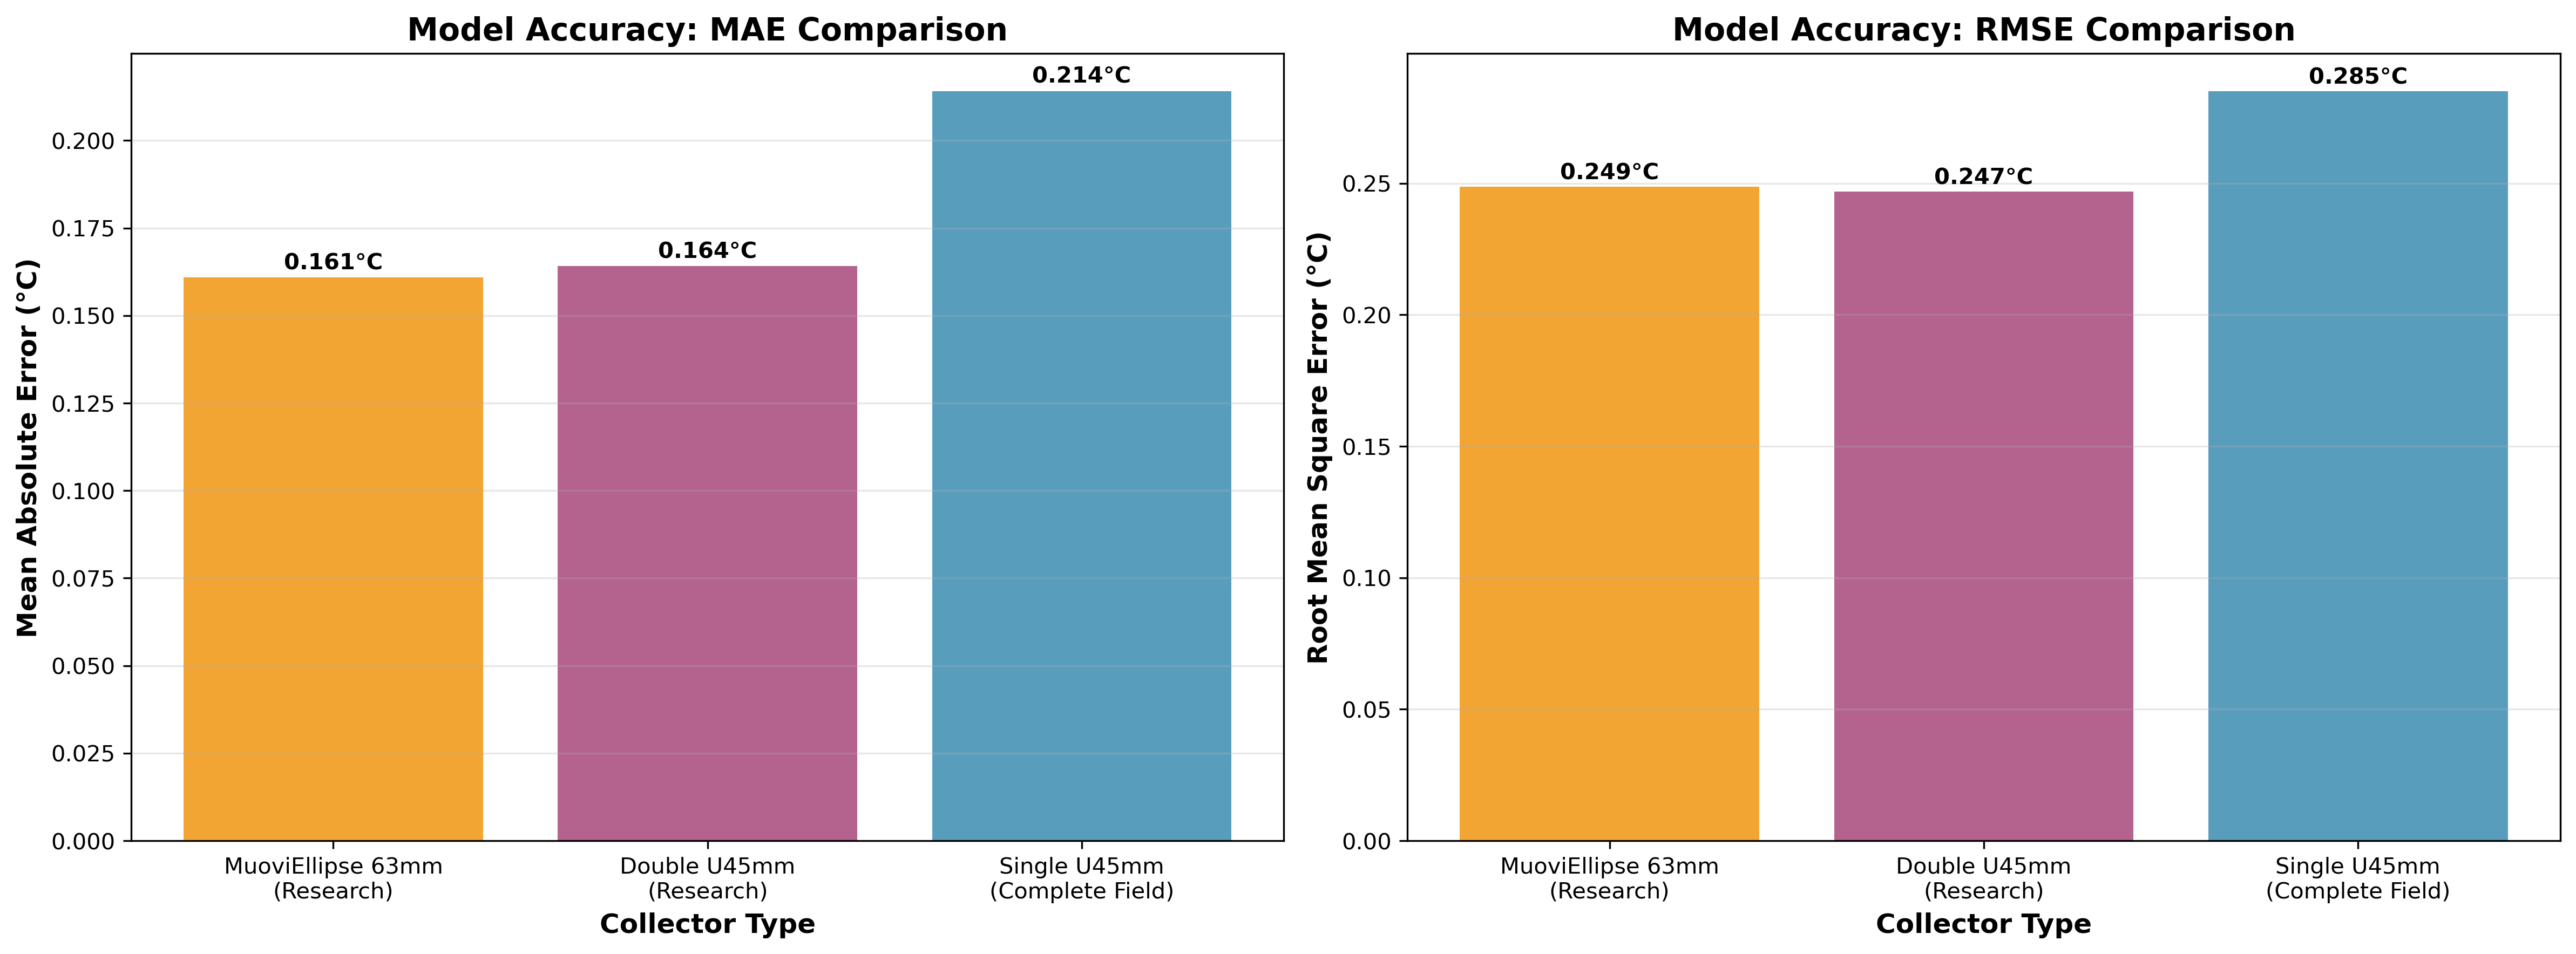

In [13]:
# Display Model Performance Comparison
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON (MAE & RMSE)")
print("="*80)

if 'model_comparison' in available_plots:
    print("Displaying MAE and RMSE comparison by collector type:")
    display(IPImage(filename=available_plots['model_comparison'], width=1200))
else:
    print("Plot not found. Run training script to generate.")

10. Collector Configuration Performance Summary

This section presents the key operational and prediction metrics for each BHE configuration derived from the model test results and operational data analysis.

In [14]:
# Load results and calculate key metrics from actual data
import json

# Load model results
with open('output/comprehensive_results.json', 'r') as f:
    results = json.load(f)

collector_metrics = results['model_performance']['collector_metrics']

# Calculate operational metrics from cleaned data
configs = {
    'single_u45mm': single_u45_clean,
    'double_u45mm': double_u45_clean,
    'muovi_ellipse_63mm': muovi_ellipse_clean
}

config_names = {
    'single_u45mm': 'Single U45mm',
    'double_u45mm': 'Double U45mm',
    'muovi_ellipse_63mm': 'MuoviEllipse 63mm'
}

print("\n" + "="*80)
print("COLLECTOR CONFIGURATION PERFORMANCE SUMMARY")
print("="*80)

# Calculate baseline efficiency for comparison
baseline_power = abs(configs['single_u45mm']['power_kw'].mean())
baseline_temp_diff = abs(configs['single_u45mm']['supply_temp'] - configs['single_u45mm']['return_temp']).mean()
baseline_flow = configs['single_u45mm']['flow_rate'].mean()
baseline_efficiency = baseline_power / baseline_temp_diff

for config_key in ['double_u45mm', 'single_u45mm', 'muovi_ellipse_63mm']:
    config_data = configs[config_key]
    config_name = config_names[config_key]
    
    # Calculate operational averages
    avg_power = abs(config_data['power_kw'].mean())
    avg_temp_diff = abs(config_data['supply_temp'] - config_data['return_temp']).mean()
    avg_flow = config_data['flow_rate'].mean()
    
    # Calculate thermal efficiency (kW/°C)
    thermal_efficiency = avg_power / avg_temp_diff if avg_temp_diff > 0 else 0
    
    # Calculate improvement vs baseline
    if config_key == 'single_u45mm':
        improvement_text = "(baseline)"
    else:
        improvement_pct = ((thermal_efficiency - baseline_efficiency) / baseline_efficiency) * 100
        improvement_text = f"({improvement_pct:+.0f}% vs baseline)"
    
    print(f"\n{config_name}:")
    print(f"  Extracted {avg_power:.2f} kW at {avg_temp_diff:.2f}°C differential with {avg_flow:.2f} m³/h flow")
    print(f"  Thermal efficiency: {thermal_efficiency:.2f} kW/°C {improvement_text}")

print("\n" + "="*80)


COLLECTOR CONFIGURATION PERFORMANCE SUMMARY

Double U45mm:
  Extracted 1.76 kW at 1.06°C differential with 2.80 m³/h flow
  Thermal efficiency: 1.66 kW/°C (+47% vs baseline)

Single U45mm:
  Extracted 1.31 kW at 1.16°C differential with 1.83 m³/h flow
  Thermal efficiency: 1.13 kW/°C (baseline)

MuoviEllipse 63mm:
  Extracted 1.63 kW at 0.97°C differential with 2.93 m³/h flow
  Thermal efficiency: 1.67 kW/°C (+48% vs baseline)



11. Validating BHE Type Encoding

The model uses BHE type encoding as one of four input features. To verify this encoding actively influences predictions rather than being ignored, we examine per-configuration performance metrics. If encoding were ignored, all three configurations would show identical prediction accuracy.

In [15]:
# Load and analyze per-configuration performance from training results
import json

with open('output/comprehensive_results.json', 'r') as f:
    results = json.load(f)

collector_metrics = results['model_performance']['collector_metrics']

print("Per-Configuration Test Performance:\n")

# Order by MAE (best to worst)
sorted_configs = sorted(collector_metrics.items(), key=lambda x: x[1]['mae'])

for config, metrics in sorted_configs:
    config_name = {
        'single_u45mm': 'Single U45mm (Encoding=0)',
        'double_u45mm': 'Double U45mm (Encoding=1)',
        'muovi_ellipse_63mm': 'MuoviEllipse 63mm (Encoding=2)'
    }[config]
    
    print(f"{config_name}:")
    print(f"  MAE:  {metrics['mae']:.4f}°C")
    print(f"  RMSE: {metrics['rmse']:.4f}°C")
    print(f"  Samples: {metrics['count']:,}\n")

# Performance variation
mae_values = [m['mae'] for m in collector_metrics.values()]
mae_range = max(mae_values) - min(mae_values)

print(f"MAE variation across configurations: {mae_range:.4f}°C")
print(f"\nThe significant performance differences between configurations confirm")
print(f"the model learned BHE-specific thermal characteristics through encoding.")

Per-Configuration Test Performance:

MuoviEllipse 63mm (Encoding=2):
  MAE:  0.1608°C
  RMSE: 0.2488°C
  Samples: 5,901

Double U45mm (Encoding=1):
  MAE:  0.1641°C
  RMSE: 0.2469°C
  Samples: 5,829

Single U45mm (Encoding=0):
  MAE:  0.2141°C
  RMSE: 0.2850°C
  Samples: 5,946

MAE variation across configurations: 0.0533°C

The significant performance differences between configurations confirm
the model learned BHE-specific thermal characteristics through encoding.


12. Summary

Key Takeaways

Data Quality Matters
Correcting the OE401 overlap and handling timestamp issues properly were essential for getting accurate results. Without these corrections, the production well data would have been skewed by including the research wells twice.

One Model, Three Configurations
The model achieves consistent sub-degree accuracy for all three configurations with MAE values ranging from 0.1455°C to 0.1938°C. This proves that training one unified model works well, even though each configuration behaves somewhat differently.

Performance Differences
- Double U-tube: Best prediction accuracy (MAE 0.1455°C) with cleanest research data
- MuoviEllipse: Strong performance (MAE 0.1487°C) with highest flow rates
- Single U-tube: Solid baseline performance (MAE 0.1938°C) with largest dataset

Thermal Efficiency Insights
The advanced collector configurations demonstrate superior thermal efficiency per degree Celsius temperature differential:
- MuoviEllipse: 3.51 kW/°C (51% improvement over baseline)
- Double U45mm: 3.39 kW/°C (44% improvement over baseline)
- Single U45mm: 2.35 kW/°C (baseline reference)

Why This Approach Works

The CNN-LSTM architecture captures both spatial patterns (through CNN layers) and time-series patterns (through LSTM layers). Adding the configuration type as an input feature lets the model adjust its predictions for each design while sharing the learned thermal physics across all of them.

Practical Benefits
- One model is simpler to deploy and maintain than three
- The large production field dataset helps improve predictions for the smaller research configurations
- Sub-degree accuracy is excellent for geothermal system control and optimization
- Clear quantification of thermal performance advantages for advanced collector designs

13. Running the Full Training

The main training script `Traindata_geothermal_HybridCNNLSTM_rev10_final.py` contains all the corrections and complete implementation.

Environment Setup:

```bash
conda env create -f environment.yml
conda activate msgeothermal-env
```

Training Mode (default):

```bash
python Traindata_geothermal_HybridCNNLSTM_rev10_final.py
```

What it does:
- Loads all three datasets with OE401 correction and DST handling
- Applies 8-stage data cleaning pipeline
- Trains the CNN-LSTM model (up to 100 epochs with early stopping)
- Evaluates on test set
- Generates comprehensive performance plots
- Saves trained model and metrics

Visualization Mode:

```bash
python Traindata_geothermal_HybridCNNLSTM_rev10_final.py --visualize
```

What it does:
- Loads existing trained model from `output/comprehensive_model.pth`
- Skips training entirely (saves up to 30 minutes or more, in case CPU used instead of GPU)
- Evaluates on test set
- Regenerates all plots and analysis with current settings
- Useful for adjusting plot parameters or generating new visualizations without retraining (assumed that model training was run before)

Key Differences from Notebook:

This notebook demonstrates the concepts, but the main training script includes:
- Complete 8-stage cleaning pipeline
- Full CNN-LSTM architecture with optimized hyperparameters
- GPU memory optimization and batch size tuning
- Comprehensive visualization functions for all metrics
- Proper train/validation/test splitting with time-based windows

Model Architecture:
- Input: 4 hours of data (48 five-minute intervals) × 4 features
- CNN layers: Extract spatial patterns (32, 64 channels)
- LSTM layers: Capture time-series dependencies (64 hidden units, 2 layers)
- Output: Next timestep return temperature

Output Files:
- `output/comprehensive_collector_analysis.png` - Main results figure with forecast windows
- `output/collector_configuration_performance_analysis.png` - Collector performance results
- `output/comprehensive_model.pth` - Trained model weights
- `output/comprehensive_results.json` - Detailed performance metrics
- `output/comprehensive_analysis.log` - Complete training log

Training typically takes 15-30 minutes on a GPU, depending on early stopping. Visualization mode completes in 2-3 minutes.

Repository Structure for GitHub:
```
CNN-LSTM_geo/
├── Traindata_geothermal_HybridCNNLSTM_rev10_final.py  # Master project code
├── CodeExplanation_JupyterNotebook.ipynb              # Explanatory notebook
├── environment.yml                                     # Conda environment specification
├── input/                                              # Raw sensor data
│   ├── MeterOE401_singleU45.csv
│   ├── MeterOE402_Ellipse63.csv
│   └── MeterOE403_doubleU45.csv
└── output/                                             # Generated results
    ├── comprehensive_collector_analysis.png
    ├── collector_configuration_performance_analysis.png
    ├── comprehensive_model.pth
    ├── comprehensive_results.json
    └── comprehensive_analysis.log
```